## Introduction
Les systèmes linéaires invariants (SLI) sont à la base de très nombreux traitements des signaux : communications numériques pour égaliser l'effet du canal de transmission, en débruitage de signaux mesurés par des capteurs physiques ou encore en reproduction du son pour rééquilibrer la balance graves/aigus. Dans ce notebook, on étudiera quelques exemples simples de la classe de SLI la plus courante : les SLI à fonction de transfert rationnelle. Pour l'instant on les définira dans le domaine temporel : l'échantillon de sortie courant $y(n)$ est calculé comme une *somme pondérée* des échantillons d'entrée et de ceux de sortie déjà calculés ($y(k)$ pour $k \leq n-1$). Soit finalement : 

\begin{align}
y(n) = b_{-Q}x(n+Q)&+b_{-Q+1}x(n+Q-1)+\ldots+b_{P-1}x(n-P+1)+b_{P}x(n-P)\\
&+a_{1}y(n-1)+a_{2}y(n-2)+\ldots+a_{R}y(n-R) 
\end{align}

On voit donc que ce calcul se scinde en une partie de *moyenne glissante* de l'entrée et de *récursion* sur les valeurs déjà calculées de la sortie. Dans la suite, on va s'intéresser à deux "paradigmes" de ce type de SLI : le filtre moyenneur et le filtre récursif d'ordre 1. 

Pour appréhender l'effet de ces filtres deux jeux de données sont fournies : 
* réchauffement climatique : des données de concentration en CO2 mesurées au somment du Mauna Loa à Hawaï ([co2.txt](http://perso.enst.fr/bedavid/OASIS/Signaux/co2.txt))
* en audio : une boucle libre de droits ([myloop.wav](http://perso.enst.fr/bedavid/OASIS/Signaux/myloop.wav))

#### mots clefs : 
Systèmes Linéaires Invariants, moyenneur, filtre récursif, filtrage.

### Rappel packages
Nous allons utiliser les packages python 
* [sounddevice](https://pypi.python.org/pypi/sounddevice/) : pour jouer les signaux audio (numpy arrays) et enregistrer  
* [soundfile](https://pypi.python.org/pypi/SoundFile/0.8.1) : pour lire/écrire des fichiers .wav
* [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) : le package signal de scipy, qui contient notamment la fonction lfilter qui calcule $y(n)$ à l'aide de la précédente équation (dite "aux différences")
* [matplotlib.pyplot](http://matplotlib.org/api/pyplot_api.html) : pour afficher les graphes 

## Mon premier moyenneur
Un filtre simple consiste à calculer l'échantillon courant comme la moyenne arithmétique des $M$ échantillons. Par exemple avec $M=3$ : 
$$y(n)=\dfrac{1}{3}\{x(n)+x(n-1)+x(n-3)\}$$

Cela s'écrit bien comme l'équation dite "aux différences" donnée plus haut. On peut remarquer que c'est aussi l'écriture d'une convolution : $y(n)=\sum_{p\in\mathbb{Z}}h(p)x(n-p)$ avec $h(n)=1/3$ pour $n=0,1,2$ et $h(n)=0$ partout ailleurs. La fonction de transfert (FT) correspondante est donc : $H(z)=\dfrac{1+z^{-1}+z^{-2}}{3}$.

Pour comprendre quel effet produit ce filtre nous allons l'utiliser sur le fichier audio et écouter le résultat.
Pour cela nous utilisons la fonction `lfilter` du package scipy.signal. Elle prend en argument les coefficients $b$ et $a$ resp. du numérateur et du dénominateur de $H(z)$. 

In [33]:
%matplotlib inline 
#qt5 pour avoir les graphes en dehors
import sounddevice as sd
import soundfile as sf
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt

#le fichier doit se trouver dans le même répertoire que le notebook
x, Fe = sf.read('myloop.wav')
x = x[:,1]
M = 3
b = np.ones(M)/M
a = 1
xf = sig.lfilter(b,a,x)


In [28]:
#x = x/np.std(x) # normalisation rms
sd.play(x[1:20*Fe],Fe) # on joue le signal original

In [29]:
#xf = xf/np.std(xf)
sd.play(xf[1:20*Fe],Fe) # on joue le signal filtré

----

>### Questions de compréhension

1. Entendez vous un(des) effet(s) ?
2. Selon vous, quel(s) effet(s) devrait produire ce filtre ? Avez-vous des arguments mathématiques pour soutenir votre affirmation ?
3. Quelle modification/réglage pourrait-on apporter pour rendre l'effet plus évident ?
4. Décommenter les lignes de normalisation de la forme `x/np.std(x)`, écoutez à nouveau et interprétez. 
----


### Mise en évidence des propriétés spectrales

Pour tracer la réponse en fréquence du filtre, il existe la fonction `freqz` utilisée ci-dessous.


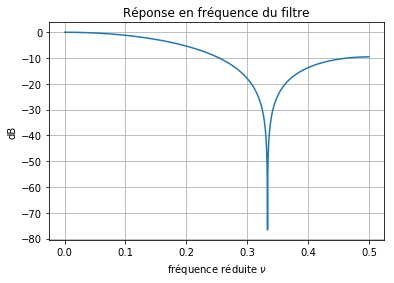

In [44]:
pi = np.pi
w,h = sig.freqz(b,a,4096)

hdb = 20*np.log10(np.abs(h))
plt.plot(w/2/pi,hdb)
plt.grid()
plt.xlabel(r'fréquence réduite $\nu$')
plt.ylabel('dB')
plt.title('Réponse en fréquence du filtre')
plt.show()

----
>### Interprétation

Interpréter les résultats obtenus en fonction de vos écoutes et de vos calculs :

*ici votre réponse*

----

## Mon premier filtre récursif

Le filtre récursif le plus simple réalise l'opération entrée/sortie suivante : 
$y(n)=\alpha y(n-1)+x(n)$. En vous inspirant de ce qui précède, filtrer le signal audio fourni à l'aide de ce SLI avec $\alpha =0.75$.


In [65]:
# ici votre code
x, Fe = sf.read('myloop.wav')
x = x[:,1]
alpha = 0.75
b = [1]
a = [1 , -alpha]
xf = sig.lfilter(b,a,x)

In [68]:
x = x/np.std(x) # normalisation rms
sd.play(x,Fe) # on joue le signal original

In [69]:
xf = xf/np.std(xf) # normalisation rms
sd.play(xf,Fe) # on joue le signal filtré

---
>### Questions et interprétations

Répondre aux mêmes questions/interprétations que précédemment.

>*ici vos réponses*

---

-------

## Etude du réchauffement climatique

On veut observer la tendance à l'accroissement de la proportion de CO2 liée au réchauffement climatique. Pour cela, nous cherchons ici à réduire la composante saisonnière (oscillations).

Le code ci-dessous vous permet de charger le fichier et d'afficher les données, ensuite c'est à vous d'utiliser le moyenneur et/ou le filtre récursif vus plus haut pour obtenire l'effet souhaité. Etapes conseillées :

>1. Analyse des données (temporelle,spectrale) : pouvez vous interpréter les données et leur spectre ? proposer un modèle mathématique pour ces données ?
2. A l'aide de `freqz` et de vos calculs ajuster les paramètres ($M$,$\alpha$) des filtres pour obtenir une visualisation de la tendance générale la meilleure possible, soit avec un moyenneur soit avec un filtre récursif.
3. Faire un choix entre ces 2 filtres. Ecrire les raisons de ce choix.
4. A quel compromis, limites doit-on faire face ?




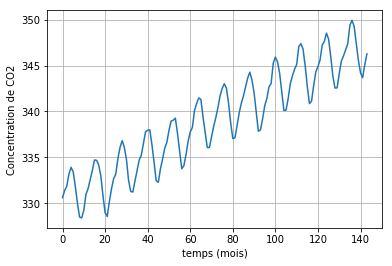

In [96]:
#-*- coding: utf-8 -*-
x = np.loadtxt('co2.txt',skiprows=4)
plt.plot(x)
plt.xlabel('temps (mois)')
plt.ylabel('Concentration de CO2')
plt.grid()
plt.show()

In [1]:
# votre code ici
